In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from lid_driven_cavity import operators, states, postprocessing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=2000, threshold=5000, precision=6)

Inputs

In [67]:
Re = 5000  # Reynolds number
N = 3  # number of cells in one direction
h = 1.0 / N  # grid spacing
k = 0.1  # timestep size
n = 0  # timestep index
max_n = 100  # maximum timestep index

Setup

In [68]:
# 1. Assume phi_n, u_n, v_n are known at all points
# phi_n = states.State(np.zeros((N+2, N+2)), Nx=N+2, Ny=N+2)
# u_n   = states.State(np.zeros((N+2, N+1)), Nx=N+1, Ny=N+2)
# v_n   = states.State(np.zeros((N+1, N+2)), Nx=N+2, Ny=N+1)
phi_n = states.State(np.arange(((N+2)*(N+2))), Nx=N+2, Ny=N+2)
u_n   = states.State(np.arange(((N+2)*(N+1))), Nx=N+1, Ny=N+2)
v_n   = states.State(np.arange(((N+1)*(N+2))), Nx=N+2, Ny=N+1)
print(f"phi_n ({phi_n.Nx:}, {phi_n.Ny:d}) = \n", phi_n)
print(f"u_n ({u_n.Nx:d}, {u_n.Ny:d}) = \n", u_n)
print(f"v_n ({v_n.Nx:d}, {v_n.Ny:d}) = \n", v_n)

phi_n (5, 5) = 
 [[20 21 22 23 24]
 [15 16 17 18 19]
 [10 11 12 13 14]
 [ 5  6  7  8  9]
 [ 0  1  2  3  4]]
u_n (4, 5) = 
 [[16 17 18 19]
 [12 13 14 15]
 [ 8  9 10 11]
 [ 4  5  6  7]
 [ 0  1  2  3]]
v_n (5, 4) = 
 [[15 16 17 18 19]
 [10 11 12 13 14]
 [ 5  6  7  8  9]
 [ 0  1  2  3  4]]


In [69]:
# 2. Assume Gx_phi_n, Gy_phi_n are known at all points
Gx_phi_n = operators.compute_gradient_x(phi_n)
Gy_phi_n = operators.compute_gradient_y(phi_n)
Gx_phi_n = states.State(Gx_phi_n.get_matrix()[:, 1:], Nx=Gx_phi_n.Nx-1, Ny=Gx_phi_n.Ny)
Gy_phi_n = states.State(Gy_phi_n.get_matrix()[:-1, :], Nx=Gy_phi_n.Nx, Ny=Gy_phi_n.Ny-1)
print(f"Gx_phi_n ({Gx_phi_n.Nx:d}, {Gx_phi_n.Ny:d}) = \n", Gx_phi_n)
print(f"Gy_phi_n ({Gy_phi_n.Nx:d}, {Gy_phi_n.Ny:d}) = \n", Gy_phi_n)

Gx_phi_n (4, 5) = 
 [[4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]]
Gy_phi_n (5, 4) = 
 [[20. 20. 20. 20. 20.]
 [20. 20. 20. 20. 20.]
 [20. 20. 20. 20. 20.]
 [20. 20. 20. 20. 20.]]


In [70]:
# 3. Assume Nu_nm1, Nv_nm1 are known at interior points
Nu_nm1 = states.State(np.zeros((N, N-1)), Nx=N-1, Ny=N)
Nv_nm1 = states.State(np.zeros((N-1, N)), Nx=N, Ny=N-1)
Nu_nm1.pad_boundaries()
Nv_nm1.pad_boundaries()
print(f"Nu_nm1 ({Nu_nm1.Nx:d}, {Nu_nm1.Ny:d})= \n", Nu_nm1)
print(f"Nv_nm1 ({Nv_nm1.Nx:d}, {Nv_nm1.Ny:d})= \n", Nv_nm1)

Nu_nm1 (4, 5)= 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Nv_nm1 (5, 4)= 
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


Prediction step

In [71]:
# 4. Compute u_hat_n, v_hat_n at interior points
u_hat_n = operators.compute_interpolated_x(u_n)
v_hat_n = operators.compute_interpolated_y(v_n)
print(f"u_hat_n ({u_hat_n.Nx:d}, {u_hat_n.Ny:d}) = \n", u_hat_n)
print(f"v_hat_n ({v_hat_n.Nx:d}, {v_hat_n.Ny:d}) = \n", v_hat_n)

u_hat_n (3, 5) = 
 [[16.5 17.5 18.5]
 [12.5 13.5 14.5]
 [ 8.5  9.5 10.5]
 [ 4.5  5.5  6.5]
 [ 0.5  1.5  2.5]]
v_hat_n (5, 3) = 
 [[12.5 13.5 14.5 15.5 16.5]
 [ 7.5  8.5  9.5 10.5 11.5]
 [ 2.5  3.5  4.5  5.5  6.5]]


In [72]:
# 5. Compute Nu, Nv at interior points
Nu = operators.compute_Nu(u_n, v_hat_n, h)
Nv = operators.compute_Nv(v_n, u_hat_n, h)
print(f"Nu ({Nu.Nx:d}, {Nu.Ny:d}) = \n", Nu)
print(f"Nv ({Nv.Nx:d}, {Nv.Ny:d}) = \n", Nv)

Nu (4, 5) = 
 [[   0.     0.     0.     0. ]
 [   0.  -394.5 -423.     0. ]
 [   0.  -256.5 -285.     0. ]
 [   0.  -118.5 -147.     0. ]
 [   0.     0.     0.     0. ]]
Nv (5, 4) = 
 [[   0.      0.      0.      0.      0.  ]
 [   0.   -302.25 -330.75 -359.25    0.  ]
 [   0.   -182.25 -210.75 -239.25    0.  ]
 [   0.      0.      0.      0.      0.  ]]


In [73]:
# 7. Solve for u_star at all points

# Compute explicit Laplacian action on u_n
Lu = operators.compute_laplace(u_n)

# Assemble RHS
b = (k/2) * (3*Nu.get_matrix()-Nu_nm1.get_matrix()) + u_n.get_matrix() + (k/2)*(1/Re)*Lu.get_matrix()
# Replace boundary values with zeros
b = states.strip_boundaries(b)
b = states.pad_boundaries(b)
# convert to vector
b = states.matrix_to_vector(b)

# Compute implicit Laplacian operator
laplacian, b = operators.assemble_laplacian_operator_u(b, Nx=N+1, Ny=N+2, h=h)
print("Laplacian = \n", laplacian.get_csr().toarray())
print("b = \n", states.vector_to_matrix(b, Nx=u_n.Nx, Ny=u_n.Ny))

# Assemble LHS
A1 = sp.sparse.eye(laplacian.shape[0], dtype=float, format='csr')
A2 = (k/2)*(1/Re)*laplacian.get_csr()
A = A1 - A2

# Solve implicit step
u_star = sp.sparse.linalg.spsolve(A, b)
u_star = states.State(u_star, Nx=N+1, Ny=N+2)
print("u_star = \n", u_star)

Laplacian = 
 [[  1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   

In [74]:
# Compute explicit Laplacian
Lv = operators.compute_laplace(v_n)

# Assemble RHS
b = (k/2) * (3*Nv.get_matrix()-Nv_nm1.get_matrix()) + v_n.get_matrix() + (k/2)*(1/Re)*Lv.get_matrix()
# replace boundary values with zeros
b = states.strip_boundaries(b)
b = states.pad_boundaries(b)
# convert to vector
b = states.matrix_to_vector(b)

# Compute implicit Laplacian operator
laplacian, b = operators.assemble_laplacian_operator_v(b, Nx=N+2, Ny=N+1, h=h)
print("Laplacian = \n", laplacian.get_csr().toarray())
print("b = \n", states.vector_to_matrix(b, Nx=v_n.Nx, Ny=v_n.Ny))

# Assemble linear system
A1 = sp.sparse.eye(laplacian.shape[0], dtype=float, format='csr')
A2 = (k/2)*(1/Re)*laplacian.get_csr()
A = A1 - A2

# Solve implicit step
v_star = sp.sparse.linalg.spsolve(A, b)
v_star = states.State(v_star, Nx=N+2, Ny=N+1)  # 5, 4
print("v_star = \n", v_star)

Laplacian = 
 [[  1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   9.   0.   0.   0.   9. -36.   9.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   9.   0.   0.   0.   9. -36.   9.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   9.   0.   0.   0.   9. -36.   9.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   

Poisson problem

In [75]:
# 8. Compute D(u_star) at interior points
dudx = (u_star.get_matrix()[:, 1:] - u_star.get_matrix()[:, :-1]) / h
dvdy = (v_star.get_matrix()[1:, :] - v_star.get_matrix()[:-1, :]) / h

dudx_interior = dudx[1:-1, :]  # remove ghost points (top/bottom rows)
dvdy_interior = dvdy[:, 1:-1]  # remove ghost points (left/right columns)

Dstar = dudx_interior + dvdy_interior
print(Dstar)

[[-241.487246 -122.645299   25.681338]
 [ -49.43196    29.167124  137.226238]
 [  25.681878   64.012898  131.795027]]


In [76]:
# 9. Solve for phi_np1 for all interior and ghost points

# Assemble RHS
b_interior = Dstar / k
# replace boundary values with zeros
b = states.pad_boundaries(b_interior)
print(b)
# convert to vector
b = states.matrix_to_vector(b)

# Compute implicit laplace operator
Lphi, b = operators.assemble_laplacian_operator_phi(b, Nx=N+2, Ny=N+2, h=h, k=k)
A = Lphi.get_csr()
print(A.toarray())

# Solve Poisson problem
phi_np1 = sp.sparse.linalg.gmres(A, b)
phi_np1 = states.State(phi_np1[0], Nx=N+2, Ny=N+2)
print(phi_np1)

[[    0.           0.           0.           0.           0.      ]
 [    0.       -2414.872456 -1226.452993   256.813383     0.      ]
 [    0.        -494.319595   291.671244  1372.262381     0.      ]
 [    0.         256.818782   640.128984  1317.95027      0.      ]
 [    0.           0.           0.           0.           0.      ]]
[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   

Correction step

In [77]:
# 10. Compute Gx_phi_np1, Gy_phi_np1 at all points
Gx_phi_np1 = operators.compute_gradient_x(phi_np1)
Gy_phi_np1 = operators.compute_gradient_y(phi_np1)

# Remove ghost-node related extra row and column
Gx_phi_np1_matrix = Gx_phi_np1.get_matrix()[:, 1:]  # remove spurious first column from ghost nodes
Gy_phi_np1_matrix = Gy_phi_np1.get_matrix()[:-1, :]  # remove spurious bottom row from ghost nodes

print(Gx_phi_np1_matrix)
print(Gy_phi_np1_matrix)

[[ 9.288300e+02 -4.824059e+02 -5.260788e+02  7.965467e+01]
 [ 3.672085e-11 -4.824059e+02 -5.260788e+02  1.194131e-08]
 [-1.175778e-08 -3.929526e+02 -4.366009e+02 -1.158901e-08]
 [ 1.201099e-08 -3.034741e+02 -3.471096e+02 -3.433342e-11]
 [-7.965647e+01 -3.034741e+02 -3.471096e+02  7.302402e+02]]
[[-9.288300e+02 -3.672085e-11 -1.169957e-08  1.194131e-08  7.965467e+01]
 [ 5.908707e+02  5.908707e+02  5.014174e+02  4.119395e+02  4.119395e+02]
 [ 4.176158e+02  4.176158e+02  3.281373e+02  2.386460e+02  2.386460e+02]
 [-7.965647e+01  1.201099e-08 -1.165080e-08  3.433342e-11 -7.302402e+02]]


In [78]:
# 11. Correct u_star to get u_np1 at all points
u_np1_matrix = u_star.get_matrix() - k * Gx_phi_np1_matrix
v_np1_matrix = v_star.get_matrix() - k * Gy_phi_np1_matrix
print(u_np1_matrix)
print(v_np1_matrix)

[[-9.088298e+01  5.024015e+01  5.460740e+01 -5.965447e+00]
 [-3.672085e-12  2.075289e+00  3.168754e+00 -1.194131e-09]
 [ 1.175778e-09  9.822613e+00  1.091333e+01  1.158901e-09]
 [-1.201099e-09  1.757291e+01  1.866264e+01  3.433342e-12]
 [ 7.965647e+00  3.034728e+01  3.471080e+01 -7.302402e+01]]
[[ 9.288300e+01  3.672085e-12  1.169957e-09 -1.194131e-09 -7.965467e+00]
 [-5.908742e+01 -9.341752e+01 -8.774968e+01 -8.207263e+01 -4.119436e+01]
 [-4.176179e+01 -6.309670e+01 -5.742519e+01 -5.174796e+01 -2.386488e+01]
 [ 7.965647e+00 -1.201099e-09  1.165080e-09 -3.433342e-12  7.302402e+01]]


In [79]:
# Confirm near-zero divergence
dudx = (u_np1_matrix[:, 1:] - u_np1_matrix[:, :-1]) / h
dvdy = (v_np1_matrix[1:, :] - v_np1_matrix[:-1, :]) / h

dudx_interior = dudx[1:-1, :]  # remove ghost points (top/bottom rows)
dvdy_interior = dvdy[:, 1:-1]  # remove ghost points (left/right columns)

divergence = dudx_interior + dvdy_interior
print(sp.linalg.norm(divergence, ord="fro"))

577.9983057336225


Bookkeeping

dphi = 8.32278e+00


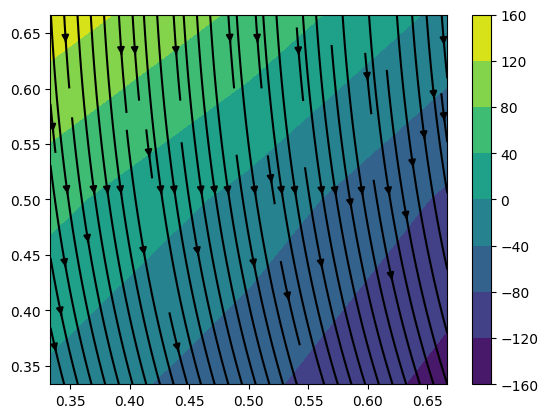

In [80]:
# Compute relative change in phi solution since last iteration (timestep)
dphi = postprocessing.relative_frobenius_error(phi_np1.get_matrix(), phi_n.get_matrix())
print(f"dphi = {dphi:.5e}")

# Update time index
n = n + 1

# Update states
phi_n = states.State(phi_np1.vector, Nx=phi_n.Nx, Ny=phi_n.Ny)
u_n = states.State(u_np1_matrix, Nx=u_n.Nx, Ny=u_n.Ny)
v_n = states.State(v_np1_matrix, Nx=v_n.Nx, Ny=v_n.Ny)

postprocessing.plot_streamlines(u_n, v_n, phi_n)

# Update gradients
Gx_phi_n = Gx_phi_np1
Gy_phi_n = Gy_phi_np1

# Update storage of prior convective (nonlinear) operator action outputs
Nu_nm1 = Nu
Nv_nm1 = Nv